In [793]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import re
import os

In [794]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
# only looking at first 10 epochs
df = df[(df['epoch'].isna()) | (df['epoch']<11)]
df.head()

C:\Users\marks\AppData\Local\Temp\ipykernel_19484\3805254241.py:2: DtypeWarning: Columns (4,6,7,8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)


,tag,value,experiment_name,step,preds_name,index,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch
0,eval_loss,1.923932,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,eval_model_preparation_time,0.002400,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eval_wer,0.634650,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,eval_mer,0.581676,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,eval_wil,0.744061,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [795]:
df.loc[[153,344],'lang_prompt']

153    NaN
344    NaN
Name: lang_prompt, dtype: object

# Metadata

In [796]:
# get more detailed colnames
metrics = ['cer', 'wer']
def get_metric(s):
    for m in metrics:
        if m in s:
            return m
    return ''
df['metric']=df['tag'].apply(get_metric)
# df.loc[df['tag'].str.contains('test'),'metric']=''
df['metric'].value_counts()

metric
       89173
wer     4565
cer     4565
Name: count, dtype: int64

In [797]:
# get eval dataset for each row
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split', 'sasoc-cs', 'sasoc-zul', 'sasoc-en', 'nchlt_zul', 'nchlt_eng', 'tira_cs']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
# ignore FLEURS and NCHLT
df=df[~df['dataset'].isin(['fl_en', 'nchlt_zul'])]
df.loc[
    df['experiment_name'].str.contains('tira')&df['dataset'].isna(),
    'dataset'
] = 'tira-cs'
df.loc[
    (df['experiment_name'].str.contains('zulu'))&df['dataset'].isna(),
    'dataset'
] = 'sasoc-cs'
df.loc[
    (df['preds_name'].fillna('').str.contains('tira')),
    'dataset'
] = 'tira-cs'
df.loc[
    (df['preds_name'].fillna('').str.contains('zulu')),
    'dataset'
] = 'sasoc-cs'
df['dataset'].value_counts(), df['dataset'].isna().sum()

(dataset
 tira-cs     49393
 sasoc-cs    47806
 Name: count, dtype: int64,
 0)

In [798]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

In [799]:
# make column "regularization"
df['ewc']=df['ewc_lambda']>0
df['lid_loss']=df['lid_loss_alpha']>0
df['regularization']='none'
df.loc[df['ewc'], 'regularization']='ewc'
df.loc[df['lid_loss'], 'regularization']='lid_loss'
df.loc[df['ewc'] & df['lid_loss'], 'regularization']='ewc+lid_loss'

In [800]:
# infer train data used from experiment name
df['train_data']='tira'
df.loc[df['experiment_name'].str.contains('tira-eng'), 'train_data']='tira-eng'
df.loc[df['experiment_name'].str.contains('tira-eng-50pct'), 'train_data']='tira-eng-50pct'
df.loc[df['experiment_name'].str.contains('tira-eng-cs'), 'train_data']='misc'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-small'), 'train_data']='tira-eng-cs-20-80-small'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-large'), 'train_data']='tira-eng-cs-20-80-large'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-50-50-large'), 'train_data']='tira-eng-cs-50-50'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-clean'), 'train_data']='tira-eng-cs-clean'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-long'), 'train_data']='tira-eng-cs-long'
df.loc[df['experiment_name'].str.contains('tira-all'), 'train_data']='tira-all'
df.loc[df['experiment_name'].str.contains('tira-all-clean'), 'train_data']='tira-all-clean'
df.loc[df['experiment_name'].str.contains('tira-all-long'), 'train_data']='tira-all-long'

df.loc[df['experiment_name'].str.contains('zulu'), 'train_data']='zulu'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng'), 'train_data']='zulu+eng'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng-50pct'), 'train_data']='zulu+eng-50pct'
df.loc[df['experiment_name'].str.contains('zulu-eng-cs'), 'train_data']='zulu-eng-cs'
df.loc[df['experiment_name'].str.contains('zulu-eng-all'), 'train_data']='zulu-eng-all'

df['train_data'].value_counts()

train_data
tira                 13906
zulu-eng-all         10661
zulu-eng-cs          10454
zulu+eng             10205
tira-eng-cs-long      9544
zulu+eng-50pct        9544
tira-eng-cs-clean     9512
tira-all-clean        8941
tira-eng              7779
zulu                  5796
tira-eng-50pct         520
tira-all-long          337
Name: count, dtype: int64

In [801]:
# use `processed` metrics for Tira and non-processed for Zulu
print(df.shape)
tira_mask = (df['dataset'].str.contains('tira'))
zulu_mask = (df['dataset'].str.contains('sasoc'))
proc_mask = (df['tag'].str.contains('processed'))
df=df[(proc_mask|~tira_mask)&(~proc_mask|~zulu_mask)]
df['tag']=df['tag'].str.replace('_processed', '')
print(df.shape)
df.loc[df['tag'].str.contains('wer'),'tag'].unique()

(97199, 26)
(48085, 26)


array(['eval_wer', 'eval_tira_wer', 'eval_eng_wer', 'eval_misc_wer',
       'eval_zulu_wer', 'test_wer', 'test_tira_wer', 'test_eng_wer',
       'test_misc_wer', 'test_zulu_wer', 'eval/wer',
       'eval/sasoc-cs-en+sw_wer'], dtype=object)

In [802]:
# df=df.sort_values('step')
# for experiment in df['experiment_name'].unique():
#     for tag in df['tag'].unique():
#         if 'loss' not in tag:
#             continue
#         loss_mask = df['tag']==tag
#         experiment_mask = df['experiment_name']==experiment
#         loss_diff = np.diff(df.loc[experiment_mask&loss_mask, 'value'])
#         loss_diff = np.insert(loss_diff, 0, 0)
#         df.loc[experiment_mask&loss_mask, 'loss_diff']=loss_diff
# df.head()


# Baseline metrics

In [803]:
baseline_mask = df['experiment_name']=='whisper-small'
df.loc[
    (baseline_mask)&
    df['preds_name'].str.contains('tira'),
    'dataset'
] = 'tira-cs'
df.loc[
    (baseline_mask)&
    df['preds_name'].str.contains('zulu'),
    'dataset'
] = 'sasoc-cs'
df.loc[baseline_mask, 'preds_name']
df.loc[baseline_mask, 'lang_prompt']=df.loc[baseline_mask, 'preds_name'].apply(
    lambda s: re.match(
        r'whisper-small/(?:tira|zulu)-([^-]+)(-test)?',
        s.replace('en-sw', 'en+sw')
    ).groups()[0])
# not sure what happened here but some junk rows got added
df=df[df['lang_prompt']!='lang']
baseline_mask = df['experiment_name']=='whisper-small'
baseline_df=df[baseline_mask]
baseline_df = baseline_df.pivot_table(index=['dataset', 'lang_prompt'], columns='tag', values='value', aggfunc=lambda x:(x[~x.isna()].item()))
baseline_df[['test_wer', 'test_cer',]]

tag                    test_wer   test_cer
dataset  lang_prompt                      
sasoc-cs en                 NaN        NaN
         en+sw              NaN        NaN
         lid          19.515205  13.540253
         sw                 NaN        NaN
tira-cs  en                 NaN        NaN
         en+sw              NaN        NaN
         lid           8.034959   6.183621
         sw                 NaN        NaN

In [804]:
df.loc[baseline_mask, ['dataset', 'lang_prompt']]

,dataset,lang_prompt
95,tira-cs,en+sw
96,tira-cs,en+sw
97,tira-cs,en+sw
98,tira-cs,en+sw
99,tira-cs,en+sw
...,...,...
2194,sasoc-cs,en
2195,sasoc-cs,en
2289,sasoc-cs,en
2290,sasoc-cs,en


### Set epoch=0 for each experiment to Whisper w/ <|en|> for Tira, Whisper w/ <|en|><|sw|> for Zulu

In [805]:
print(df.shape)
baseline_dfs = []
for exp in df['experiment_name'].unique():
    if exp=='whisper-small':
        continue
    exp_mask=(df['experiment_name']!=exp)
    dataset = 'tira-cs' if 'tira' in exp else 'sasoc-cs'
    lang_prompt = 'en' if 'tira' in exp else 'en+sw'
    baseline = df[
        (df['experiment_name']=='whisper-small')&
        (df['dataset']==dataset)&
        (df['lang_prompt']==lang_prompt)
    ].copy()
    baseline['train_data']='tira_baseline' if 'tira' in exp else 'zulu_baseline'
    baseline['epoch']=0
    baseline['regularization']=df.loc[exp_mask,'regularization'].iloc[0]
    baseline_dfs.append(baseline)
df = df[df['epoch']!=0]
print(df.shape)
df=pd.concat([df]+baseline_dfs)
df.shape

(47894, 26)
(46796, 26)


(50616, 26)

# Line plots

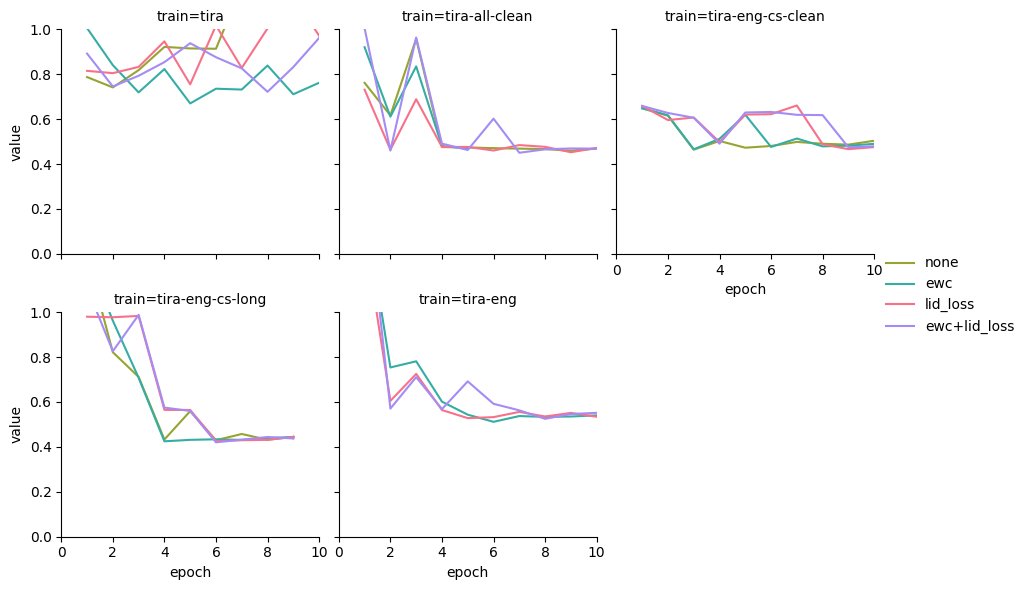

In [806]:
df['beam']=df['beam'].fillna(0).astype(float)
df['lm_alpha']=df['lm_alpha'].astype(str)
g = sb.FacetGrid(
    df[
        # (df['experiment_name'].str.contains('zulu')) &
        # ~(df['experiment_name'].str.contains('zulu-swahili-eng')) &
        (df['experiment_name'].str.contains('tira')) &
        # (~df['train_data'].str.contains('20-80'))&
        # (~df['train_data'].str.contains('misc'))&
        # (df['train_data'].str.contains('zulu-eng'))&
        # (df['train_data']!='tira-all')&
        # (df['lang_prompt']=='swahili') &
        # (df['lang_prompt']=='croatian')&
        # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
        (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
        (df['ewc_lambda'].isin([0,1])) &
        (df['lid_loss_alpha'].isin([0,0.2])) &
        # (df['beam']==2)&
        (df['beam']==0)&
        # (~df['csv_name'].isna())&
        # (df['pred_name'].isna())&
        # (df['regularization']=='none')&
        # (df['tag'].str.contains('loss'))
        # (df['tag']=='train/loss')
        (df['tag'].isin(['eval_wer']))
        # (df['metric']!='')
        # (df['LoRA'])
    ],
    # col='ewc_lambda',
    col='train_data',
    col_wrap=3,
    # row='lm_alpha',
    # col='lid_loss_alpha',
    # row='beam',
    # row='dataset',
    # sharey=False,
)
palette_map= {
    key: color for key, color in
    zip(['lid_loss', 'none', 'ewc', 'ewc+lid_loss'], sb.color_palette('husl',4))
}
g.map_dataframe(
    sb.lineplot,
    x='epoch',
    # x='step',
    y='value',
    # y='loss_diff',
    # hue='lid_loss_alpha',
    hue='regularization',
    palette=palette_map,
    # hue='ewc_lambda',
    # errorbar=None,
    legend='full',
    # style='tag',
    # style='tag',
)
# g.set_titles('eval={row_name}, train={col_name}')
g.set_titles('train={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
g.set(xlim=(0,10))
plt.show()

# Get best checkpoints for each model

In [807]:
# first need to create a mask to separate lang-specific error rates from general
lang_metrics = []
for metric in ['cer', 'wer']:
    for lang in ['eng', 'tira', 'zulu', 'misc']:
        lang_metrics.append(f"{lang}_{metric}")
has_lang_metric = lambda s: any(m in s for m in lang_metrics)
no_lang_metric_mask = ~df['tag'].apply(has_lang_metric)
df.loc[(df['metric']!='')&no_lang_metric_mask,'tag'].unique()

array(['eval_wer', 'eval_cer', 'test_wer', 'test_cer', 'eval/cer',
       'eval/wer', 'eval/sasoc-cs-en+sw_cer', 'eval/sasoc-cs-en+sw_wer'],
      dtype=object)

In [808]:
df['best_checkpoint']=False
df.loc[df['train_data'].str.contains('baseline'),'best_checkpoint']=True
epoch_past_0 = df['epoch']>0
with open('best_checkpoint.csv', 'wb') as f:
    for exp in df['experiment_name'].unique():
        if exp == 'whisper-small':
            continue
        exp_mask = df['experiment_name']==exp
        wer_mask = df['metric']=='wer'
        sorted_df = df[exp_mask&epoch_past_0&wer_mask&no_lang_metric_mask].sort_values('value')
        if len(sorted_df)==0:
            continue
        best_epoch = sorted_df.iloc[0]['epoch']
        epoch_mask = df['epoch']==best_epoch
        df.loc[exp_mask&epoch_past_0&epoch_mask,'best_checkpoint']=True

        dataset_path = '/home/mjsimmons/datasets/tira_eval' if 'tira' in exp else\
        '/home/mjsimmons/datasets/sasoc-cs'
        model_path = '/mnt/LocalStorage/mjsimmons/'+exp
        checkpoint = f"checkpoint-{sorted_df.iloc[0]['step']}"
        lang='tira' if 'tira' in exp else 'zulu'
        f.write(bytes(','.join([model_path,checkpoint,dataset_path,lang])+'\n', encoding='utf8'))

df['best_checkpoint'].value_counts()


best_checkpoint
False    38883
True     11733
Name: count, dtype: int64

In [809]:
df[df['train_data'].str.contains('baseline')]

,tag,value,experiment_name,step,preds_name,index,date,checkpoint,csv_name,lid_loss_alpha,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,best_checkpoint
191,eval_loss,5.161103,whisper-small,0,whisper-small/zulu-en+sw-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,,sasoc-cs,False,False,none,zulu_baseline,True
192,eval_model_preparation_time,0.002500,whisper-small,0,whisper-small/zulu-en+sw-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,,sasoc-cs,False,False,none,zulu_baseline,True
193,eval_wer,1.492337,whisper-small,0,whisper-small/zulu-en+sw-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,wer,sasoc-cs,False,False,none,zulu_baseline,True
194,eval_mer,0.870391,whisper-small,0,whisper-small/zulu-en+sw-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,,sasoc-cs,False,False,none,zulu_baseline,True
195,eval_wil,0.969744,whisper-small,0,whisper-small/zulu-en+sw-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,,sasoc-cs,False,False,none,zulu_baseline,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,eval_misc2eng_char_substitution_rate,0.029756,whisper-small,0,whisper-small/tira-en-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,,tira-cs,False,False,none,tira_baseline,True
948,eval_misc2misc_char_substitution_rate,0.019694,whisper-small,0,whisper-small/tira-en-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,,tira-cs,False,False,none,tira_baseline,True
949,eval_tira_cer,0.810304,whisper-small,0,whisper-small/tira-en-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,cer,tira-cs,False,False,none,tira_baseline,True
950,eval_eng_cer,0.338951,whisper-small,0,whisper-small/tira-en-test,NaN,NaN,NaN,NaN,0.0,...,nan,0.0,0.0,cer,tira-cs,False,False,none,tira_baseline,True


# Make table showing baseline and final test results: overall & lang specific

In [810]:
tira_metrics = []
for metric in ['_wer', '_cer']:
    tira_metrics.append('test'+metric)
for metric in ['_hit_rate', '_char_hit_rate']:
    for lang in ['tira', 'eng']:
        tira_metrics.append(f"test_{lang}{metric}")

df.loc[
    (df['dataset']=='tira-cs')&
    (df['best_checkpoint'])&
    (df['tag'].isin(tira_metrics))
    # (df['tag'].str.contains('test'))
].pivot_table(
    columns='tag', index=['train_data', 'regularization', 'epoch'], values='value'
)

,,tag,test_cer,test_eng_char_hit_rate,test_eng_hit_rate,test_tira_char_hit_rate,test_tira_hit_rate,test_wer
train_data,regularization,epoch,,,,,,
tira-eng,none,8.0,0.506859,0.644138,0.599628,0.157685,0.126694,0.572103


In [811]:
zero_as_baseline = df.copy()
zero_as_baseline.loc[(df['epoch']==0)&(df['dataset'].str.contains('tira')),'train_data']='tira baseline'
zero_as_baseline.loc[(df['epoch']==0)&(df['dataset'].str.contains('zulu')),'train_data']='zulu baseline'
metric_cols = zero_as_baseline[
    (df['metric']!='')&
    (df['epoch']<=10) &
    (~(df['tag']).str.contains('test')) &
    (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
    ((df['dataset'].str.contains('tira')&~df['csv_name'].isna())|(df['dataset'].str.contains('sasoc')&df['csv_name'].isna()))&
    (df['best_checkpoint']) &
    no_lang_metric_mask
].pivot_table(
    columns=['regularization'],
    values=['value'],
    index=['train_data', 'epoch', 'metric'],
    aggfunc=lambda x:((x.iloc[0])),
).pivot_table(
    index=['train_data','epoch'],
    columns=['metric'],
).droplevel(
    axis=1,
    level=0
)
metric_cols

regularization                ewc           ewc+lid_loss            lid_loss  \
metric                        cer       wer          cer       wer       cer   
train_data        epoch                                                        
tira              2.0         NaN       NaN          NaN       NaN       NaN   
                  5.0    0.582728  0.670096          NaN       NaN  0.644999   
                  8.0         NaN       NaN     0.649098  0.721879       NaN   
tira-all-clean    5.0    0.357086  0.468107          NaN       NaN       NaN   
                  7.0         NaN       NaN     0.333573  0.450274       NaN   
                  9.0         NaN       NaN          NaN       NaN  0.341483   
tira-eng          5.0         NaN       NaN          NaN       NaN  0.452794   
                  6.0    0.449989  0.511660          NaN       NaN       NaN   
                  8.0         NaN       NaN     0.463364  0.525034       NaN   
tira-eng-cs-clean 3.0    0.354426  0.465706          NaN       NaN       NaN   
                  9.0         NaN       NaN     0.349105  0.474623  0.350543   
tira-eng-cs-long  4.0    0.331272  0.424897          NaN       NaN       NaN   
                  6.0         NaN       NaN     0.330769  0.420439  0.333357   
zulu              4.0         NaN       NaN          NaN       NaN       NaN   
                  5.0         NaN       NaN     0.351552  0.703704  0.341131   
                  10.0   0.344568  0.685185          NaN       NaN       NaN   
zulu+eng          6.0    0.389911  0.705619          NaN       NaN       NaN   
                  9.0         NaN       NaN     0.272616  0.554917       NaN   
                  10.0        NaN       NaN          NaN       NaN  0.267184   
zulu+eng-50pct    5.0         NaN       NaN     0.331596  0.620051       NaN   
                  7.0    0.350554  0.634738          NaN       NaN       NaN   
                  8.0         NaN       NaN          NaN       NaN  0.333925   
zulu-eng-all      4.0         NaN       NaN     0.189246  0.423372       NaN   
                  8.0    0.186696  0.419540          NaN       NaN       NaN   
                  10.0        NaN       NaN          NaN       NaN  0.183592   
zulu-eng-cs       8.0         NaN       NaN          NaN       NaN       NaN   
                  9.0    0.220399  0.472542     0.211197  0.464879  0.215188   
zulu_baseline     0.0         NaN       NaN          NaN       NaN       NaN   

regularization                         none            
metric                        wer       cer       wer  
train_data        epoch                                
tira              2.0         NaN  0.674337  0.741427  
                  5.0    0.755144       NaN       NaN  
                  8.0         NaN       NaN       NaN  
tira-all-clean    5.0         NaN       NaN       NaN  
                  7.0         NaN       NaN       NaN  
                  9.0    0.452675  0.348098  0.459534  
tira-eng          5.0    0.528121       NaN       NaN  
                  6.0         NaN       NaN       NaN  
                  8.0         NaN       NaN       NaN  
tira-eng-cs-clean 3.0         NaN  0.352197  0.464335  
                  9.0    0.466392       NaN       NaN  
tira-eng-cs-long  4.0         NaN       NaN       NaN  
                  6.0    0.426269  0.338031  0.429698  
zulu              4.0         NaN  0.471286  0.855045  
                  5.0    0.697957       NaN       NaN  
                  10.0        NaN       NaN       NaN  
zulu+eng          6.0         NaN       NaN       NaN  
                  9.0         NaN  0.288470  0.589400  
                  10.0   0.567050       NaN       NaN  
zulu+eng-50pct    5.0         NaN       NaN       NaN  
                  7.0         NaN       NaN       NaN  
                  8.0    0.623244  0.355876  0.634100  
zulu-eng-all      4.0         NaN  0.184701  0.414432  
                  8.0         NaN       NaN       NaN  
       

In [812]:
reg_names = ['none', 'ewc', 'lid_loss', 'ewc+lid_loss']
reg_dfs = []
for reg in reg_names:
    reg_df=metric_cols[reg]
    reg_df=reg_df.sort_values('wer')
    reg_df=reg_df.reset_index()
    reg_df=reg_df.rename_axis('', axis=1)
    # reg_df=reg_df[reg_df['epoch']>0]
    reg_df=reg_df.drop_duplicates(subset=['train_data'], keep='first')
    reg_df['regularization']=reg
    reg_dfs.append(reg_df)
reg_dfs = pd.concat(reg_dfs)
table=reg_dfs.melt(
    value_vars=['cer', 'wer', 'epoch'],
    var_name='var',
    id_vars=['train_data', 'regularization']
).sort_values(
    'train_data'
).pivot_table(
    columns=['regularization', 'var'],
    index='train_data'
)
table.columns.names=[None,'regularization',None]
table=table.droplevel(0,axis=1)
table=table.reset_index()
is_tira=table['train_data'].str.contains('tira')
table = pd.concat({'Tira': table[is_tira], 'Zulu': table[~is_tira]})
table=table.rename({
    'ewc': 'EWC',
    'lid_loss': 'LID loss',
    'none': 'Plain finetune',
    'ewc+lid_loss': 'EWC+LID loss',
    'train_data': 'Train dataset',
}, axis=1)
table['Train dataset']=table['Train dataset'].map({
    'tira': 'Mono',
    'tira-all-clean': 'All (short)',
    'tira-all-long': 'All (long)',
    'tira-eng': 'Biling',
    'tira-eng-50pct': 'Biling (50\\%)',
    'tira-eng-cs-clean': "CS (short)",
    'tira-eng-cs-long': "CS (long)",
    'tira baseline': 'Baseline',
    'zulu': "Mono",
    'zulu+eng': "Biling",
    'zulu+eng-50pct': "Biling (50\\%)",
    'zulu-eng-all': 'All',
    'zulu-eng-cs': 'CS',
    'zulu baseline': 'Baseline',
})

for column in table.columns:
    if column[1]=='epoch':
        table[column]=table[column].astype(int)
    elif column[1]=='':
        pass
    elif column[1] in ('wer', 'cer'):
        table[column]=table[column].apply(lambda n:f"{n:.2f}")
for language in ['Tira', 'Zulu']:
    is_language = table.index.get_level_values(0)==language
    for column in table.columns:
        if column[1] in ('wer', 'cer'):
            min_idx = table.loc[language,column].astype(float).idxmin()
            min_val = table.at[(language,min_idx),column]
            table.loc[(is_language)&(table[column]==min_val),column]=r'\textbf{'+min_val+r'}'
split_bf = lambda s:s.removeprefix(r'\textbf{').removesuffix(r'}')
def italicize_min_per_row(row):
    if row['Train dataset'].item() == 'Baseline':
        return row
    cer = row.index.get_level_values(1)=='cer'
    min_cer_idx = row[cer].apply(split_bf).astype(float).idxmin()
    min_cer_value=row[min_cer_idx]
    row[cer&(row==min_cer_value)]=r'\textit{'+min_cer_value+r'}'

    wer = row.index.get_level_values(1)=='wer'
    min_wer_idx = row[wer].apply(split_bf).astype(float).idxmin()
    min_wer_value=row[min_wer_idx]
    row[wer&(row==min_wer_value)]=r'\textit{'+min_wer_value+r'}'
    return row
table=table.apply(italicize_min_per_row, axis=1)
table=table.loc[:,table.columns.get_level_values(1)!='epoch']
table=pd.concat({
    'Tira':table.loc['Tira'].set_index('Train dataset'),
    'Zulu':table.loc['Zulu'].set_index('Train dataset'),
})
table.columns.names=None,None
ordered_cols = []
for reg in ['Plain finetune', 'EWC', 'LID loss', 'EWC+LID loss']:
    for metric in ['wer', 'cer']:
        ordered_cols.append((reg,metric))
table=table[ordered_cols]
ordered_rows = []
for ds in ['Baseline', 'Mono', 'Biling', 'Biling (50\%)', 'CS (short)', 'CS (long)', 'All (short)', 'All (long)']:
# for ds in ['Baseline', 'Mono', 'All (short)', 'CS', 'Biling']:
    ordered_rows.append(('Tira', ds))
for ds in ['Baseline', 'Mono', 'Biling', 'Biling (50\%)', 'CS', 'All']:
    ordered_rows.append(('Zulu', ds))
table=table.loc[ordered_rows]
table

KeyError: "[('Tira', 'Baseline'), ('Tira', 'Biling (50\\\\%)'), ('Tira', 'All (long)'), ('Zulu', 'Baseline')] not in index"

In [ ]:
with open('table.tex', 'w') as f:
    latex_str=table.to_latex(index=True, escape=False, sparsify=True, multirow=False)
    latex_str=latex_str.replace(r'\multicolumn{2}{r}', r'\multicolumn{2}{l}')
    latex_str=latex_str.replace('Zulu','\midrule\nisiZulu')
    f.write(latex_str)